1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X). 
2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our **TARGET** (y) variable.
3. Read the data into a Pandas dataframe.  At this point you should have 1000 rows.  Number of columns depends on the number of features you chose.
4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.
5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.
6. Evaluate the results.

Libraries (just in case, I bring all)

In [598]:
import pandas as pd #tablas https://pandas.pydata.org/docs/user_guide/pyarrow.html
import numpy as np #estadistica https://numpy.org/doc/1.25/user/index.html#user
import matplotlib.pyplot as plt #gráficos https://matplotlib.org/stable/plot_types/index.html
import seaborn as sns #gráficos https://seaborn.pydata.org/tutorial/regression.html
from sklearn import linear_model #modelo de regresion https://scikit-learn.org/stable/
from sklearn.preprocessing import MinMaxScaler # do not use the function Normalise() - it does something entirely different
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from datetime import datetime #https://docs.python.org/3/library/datetime.html
from datetime import timedelta #this is a good time to learn about dates and timestamps. You can find some info here:
from sklearn.linear_model import LogisticRegression
import pymysql                        # for getting data from a SQL database
from sqlalchemy import create_engine  # for establishing the connection and authentication
from getpass import getpass  # To get the password without showing the input

1. Getting the data

In [599]:
password = getpass() #Contraseña del servidor MySQL

In [600]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT f.title as film_title,
                f.film_id,
                  f.rental_duration,
                  f.rental_rate,
                  f.rating,
                  f.length,
                  f.replacement_cost,
                  COUNT(DISTINCT r.rental_id) AS rental_count,
                  COUNT(DISTINCT i.inventory_id) AS inventory_count,
                  COUNT(DISTINCT fa.actor_id) AS actor_count,
                  CASE 
                      WHEN f.title IN
                          (SELECT DISTINCT f.title as film_title
                           FROM film f
                           JOIN inventory i USING (film_id)
                           JOIN rental USING (inventory_id)
                           WHERE rental.rental_date LIKE "2005-05%%")
                      THEN "1"
                      ELSE "0"
                  END AS rented_in_may
          FROM film f
          LEFT JOIN inventory i USING (film_id)
          LEFT JOIN rental r USING (inventory_id)
          LEFT JOIN film_category fc USING (film_id)
          LEFT JOIN film_actor fa USING (film_id)
          GROUP BY f.film_id;'''

film = pd.read_sql_query(query, engine)
film

,film_title,film_id,rental_duration,rental_rate,rating,length,replacement_cost,rental_count,inventory_count,actor_count,rented_in_may
0,ACADEMY DINOSAUR,1,6,0.99,PG,86,20.99,23,8,10,1
1,ACE GOLDFINGER,2,3,4.99,G,48,12.99,7,3,4,0
2,ADAPTATION HOLES,3,7,2.99,NC-17,50,18.99,12,4,5,1
3,AFFAIR PREJUDICE,4,5,2.99,G,117,26.99,23,7,5,1
4,AFRICAN EGG,5,6,2.99,G,130,22.99,12,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,996,6,0.99,G,183,9.99,7,2,5,0
996,YOUTH KICK,997,4,0.99,NC-17,179,14.99,6,2,5,0
997,ZHIVAGO CORE,998,6,0.99,NC-17,105,10.99,9,2,6,1
998,ZOOLANDER FICTION,999,5,2.99,R,101,28.99,17,5,5,1


In [601]:
query1 = 'SELECT film_category.film_id, category.name AS category_name FROM sakila.film_category JOIN sakila.category USING (category_id)'
film_category = pd.read_sql_query(query1, engine)
film_category

film = pd.merge(left=film,right=film_category,how = 'inner',left_on = 'film_id', right_on='film_id')

film = film.drop("film_id", axis=1)
film

,film_title,rental_duration,rental_rate,rating,length,replacement_cost,rental_count,inventory_count,actor_count,rented_in_may,category_name
0,ACADEMY DINOSAUR,6,0.99,PG,86,20.99,23,8,10,1,Documentary
1,ACE GOLDFINGER,3,4.99,G,48,12.99,7,3,4,0,Horror
2,ADAPTATION HOLES,7,2.99,NC-17,50,18.99,12,4,5,1,Documentary
3,AFFAIR PREJUDICE,5,2.99,G,117,26.99,23,7,5,1,Horror
4,AFRICAN EGG,6,2.99,G,130,22.99,12,3,5,1,Family
...,...,...,...,...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,6,0.99,G,183,9.99,7,2,5,0,Documentary
996,YOUTH KICK,4,0.99,NC-17,179,14.99,6,2,5,0,Music
997,ZHIVAGO CORE,6,0.99,NC-17,105,10.99,9,2,6,1,Horror
998,ZOOLANDER FICTION,5,2.99,R,101,28.99,17,5,5,1,Children


In [602]:
film.isna().sum().sum()

0

In [603]:

numerical_columns= film.select_dtypes(include=[np.number]) 
numerical_columns.describe()

,rental_duration,rental_rate,length,replacement_cost,rental_count,inventory_count,actor_count
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.985000,2.980000,115.272000,19.984000,16.044000,4.581000,5.462000
std,1.411654,1.646393,40.426332,6.050833,7.348065,2.020277,2.337524
min,3.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000
25%,4.000000,0.990000,80.000000,14.990000,11.000000,3.000000,4.000000
50%,5.000000,2.990000,114.000000,19.990000,16.000000,5.000000,5.000000
75%,6.000000,4.990000,149.250000,24.990000,21.000000,6.000000,7.000000
max,7.000000,4.990000,185.000000,29.990000,34.000000,8.000000,15.000000


In [604]:
categorical_columns = film.select_dtypes(include='object') #Solo columnas objeto
categorical_columns.describe()

,film_title,rating,rented_in_may,category_name
count,1000,1000,1000,1000
unique,1000,5,2,16
top,ACADEMY DINOSAUR,PG-13,1,Sports
freq,1,223,686,74


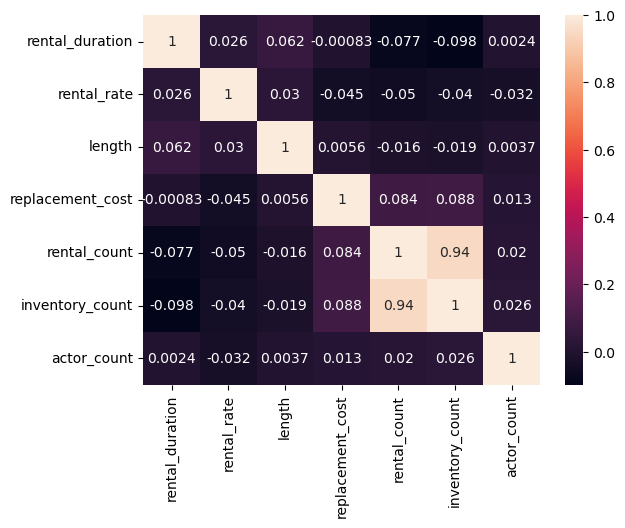

In [605]:
correlations_matrix = numerical_columns.corr()
sns.heatmap(correlations_matrix, annot=True)  #Mapa de calor de correlaciones
plt.show()

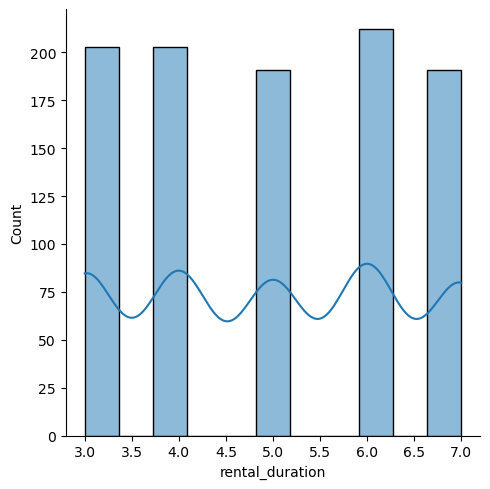

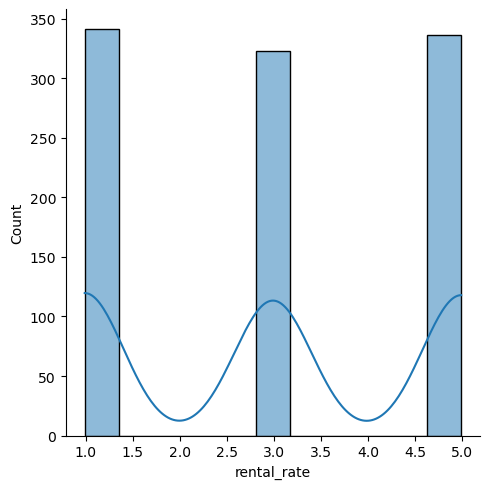

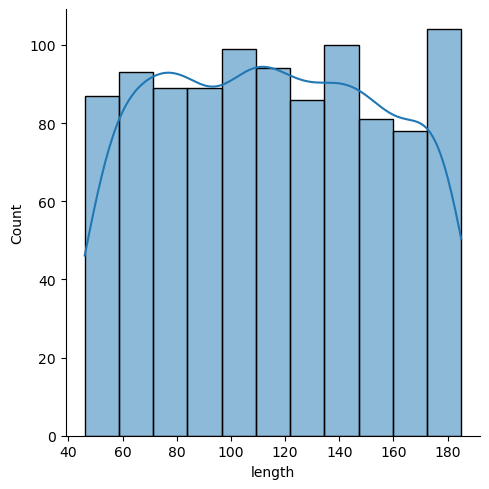

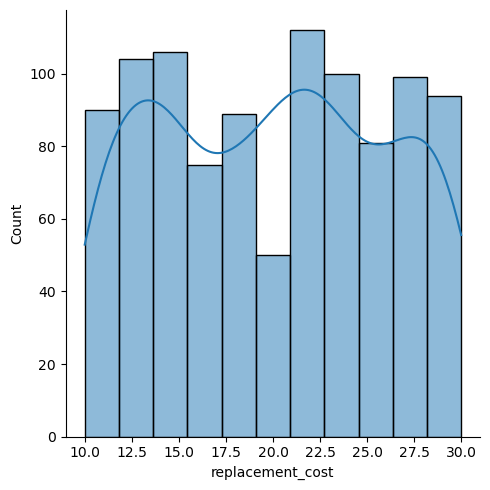

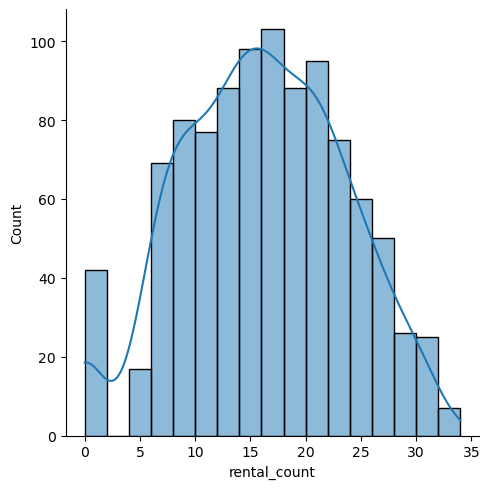

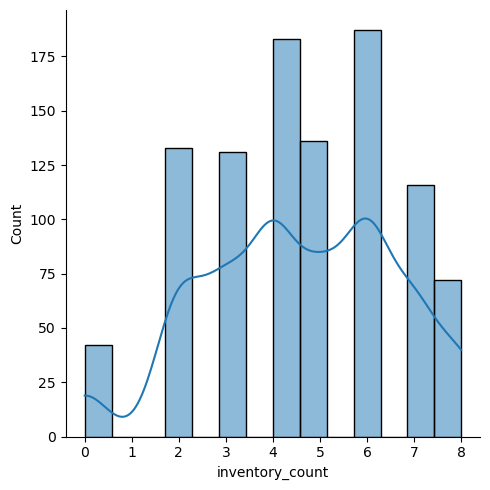

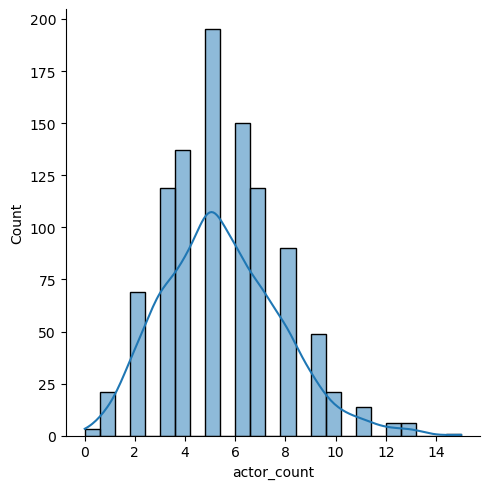

In [606]:
sns.displot(film['rental_duration'], kde=True)
plt.show()

sns.displot(film['rental_rate'], kde=True)
plt.show()

sns.displot(film['length'], kde=True)
plt.show()

sns.displot(film['replacement_cost'], kde=True)
plt.show()

sns.displot(film['rental_count'], kde=True)
plt.show()

sns.displot(film['inventory_count'], kde=True)
plt.show()

sns.displot(film['actor_count'], kde=True)
plt.show()

DROPING FILM_TITLE AND RENTAL_COUNT

In [607]:
film = film.drop("film_title" , axis=1)
film

,rental_duration,rental_rate,rating,length,replacement_cost,rental_count,inventory_count,actor_count,rented_in_may,category_name
0,6,0.99,PG,86,20.99,23,8,10,1,Documentary
1,3,4.99,G,48,12.99,7,3,4,0,Horror
2,7,2.99,NC-17,50,18.99,12,4,5,1,Documentary
3,5,2.99,G,117,26.99,23,7,5,1,Horror
4,6,2.99,G,130,22.99,12,3,5,1,Family
...,...,...,...,...,...,...,...,...,...,...
995,6,0.99,G,183,9.99,7,2,5,0,Documentary
996,4,0.99,NC-17,179,14.99,6,2,5,0,Music
997,6,0.99,NC-17,105,10.99,9,2,6,1,Horror
998,5,2.99,R,101,28.99,17,5,5,1,Children


In [608]:
film = film.drop("rental_count" , axis=1)
film

,rental_duration,rental_rate,rating,length,replacement_cost,inventory_count,actor_count,rented_in_may,category_name
0,6,0.99,PG,86,20.99,8,10,1,Documentary
1,3,4.99,G,48,12.99,3,4,0,Horror
2,7,2.99,NC-17,50,18.99,4,5,1,Documentary
3,5,2.99,G,117,26.99,7,5,1,Horror
4,6,2.99,G,130,22.99,3,5,1,Family
...,...,...,...,...,...,...,...,...,...
995,6,0.99,G,183,9.99,2,5,0,Documentary
996,4,0.99,NC-17,179,14.99,2,5,0,Music
997,6,0.99,NC-17,105,10.99,2,6,1,Horror
998,5,2.99,R,101,28.99,5,5,1,Children


In [613]:
numerical_columns = numerical_columns.drop("rental_count", axis=1)
numerical_columns

KeyError: "['rental_count'] not found in axis"

X-Y TRAIN

In [614]:
y = film['rented_in_may']
X = film.drop('rented_in_may', axis=1)

In [615]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=400)

MIN-MAX scale

In [616]:
X_train_num = X_train.select_dtypes(include=[np.number])  

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns=numerical_columns.columns)
X_train_norm

,rental_duration,rental_rate,length,replacement_cost,inventory_count,actor_count
0,0.25,0.5,0.654676,0.80,0.625,0.400000
1,0.25,1.0,0.151079,0.00,0.375,0.333333
2,0.00,1.0,0.446043,0.20,0.375,0.200000
3,0.25,0.5,0.007194,0.65,0.875,0.533333
4,1.00,0.5,0.575540,0.50,0.750,0.266667
...,...,...,...,...,...,...
795,0.75,1.0,1.000000,0.10,0.625,0.533333
796,1.00,1.0,0.194245,0.45,0.000,0.333333
797,0.25,0.5,0.568345,0.65,0.875,0.133333
798,0.00,0.5,0.438849,0.20,0.875,0.133333


Transform categorical into numerical with train data

In [617]:
X_train_categorical = X_train.select_dtypes(include = object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rating', 'category_name'],
                             drop_first=True)
X_train_cat.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,category_name_Documentary,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,category_name_Horror,category_name_Music,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel
805,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
626,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
45,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
868,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
799,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [618]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

Logistic regression model

In [619]:
classification = LogisticRegression(random_state=0,
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [620]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)
X_test_norm.head()

,0,1,2,3,4,5
0,0.50,0.0,0.683453,0.00,0.875,0.333333
1,0.25,0.5,0.496403,0.20,0.375,0.466667
2,0.25,0.5,0.431655,0.05,0.750,0.333333
3,0.50,1.0,0.669065,0.85,0.875,0.266667
4,0.00,1.0,0.956835,0.90,1.000,0.333333


In [621]:
# for categoricals
X_test_categorical = X_test.select_dtypes(include = object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['rating', 'category_name'],
                            drop_first=True)

In [622]:
X_test_cat.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,category_name_Documentary,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,category_name_Horror,category_name_Music,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel
862,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
699,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
350,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
243,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
896,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [623]:
X_train_cat.columns

Index(['rating_NC-17', 'rating_PG', 'rating_PG-13', 'rating_R',
       'category_name_Animation', 'category_name_Children',
       'category_name_Classics', 'category_name_Comedy',
       'category_name_Documentary', 'category_name_Drama',
       'category_name_Family', 'category_name_Foreign', 'category_name_Games',
       'category_name_Horror', 'category_name_Music', 'category_name_New',
       'category_name_Sci-Fi', 'category_name_Sports', 'category_name_Travel'],
      dtype='object')

In [624]:
X_test_cat.columns

Index(['rating_NC-17', 'rating_PG', 'rating_PG-13', 'rating_R',
       'category_name_Animation', 'category_name_Children',
       'category_name_Classics', 'category_name_Comedy',
       'category_name_Documentary', 'category_name_Drama',
       'category_name_Family', 'category_name_Foreign', 'category_name_Games',
       'category_name_Horror', 'category_name_Music', 'category_name_New',
       'category_name_Sci-Fi', 'category_name_Sports', 'category_name_Travel'],
      dtype='object')

In [625]:
list(zip(list(X_train_cat.columns),list(X_test_cat.columns)))

[('rating_NC-17', 'rating_NC-17'),
 ('rating_PG', 'rating_PG'),
 ('rating_PG-13', 'rating_PG-13'),
 ('rating_R', 'rating_R'),
 ('category_name_Animation', 'category_name_Animation'),
 ('category_name_Children', 'category_name_Children'),
 ('category_name_Classics', 'category_name_Classics'),
 ('category_name_Comedy', 'category_name_Comedy'),
 ('category_name_Documentary', 'category_name_Documentary'),
 ('category_name_Drama', 'category_name_Drama'),
 ('category_name_Family', 'category_name_Family'),
 ('category_name_Foreign', 'category_name_Foreign'),
 ('category_name_Games', 'category_name_Games'),
 ('category_name_Horror', 'category_name_Horror'),
 ('category_name_Music', 'category_name_Music'),
 ('category_name_New', 'category_name_New'),
 ('category_name_Sci-Fi', 'category_name_Sci-Fi'),
 ('category_name_Sports', 'category_name_Sports'),
 ('category_name_Travel', 'category_name_Travel')]

In [626]:
list(X_train_cat.columns)==list(X_test_cat.columns)

True

In [627]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [628]:
predictions = classification.predict(X_test_transformed)
predictions
classification.score(X_test_transformed, y_test)

0.775

In [629]:
print(y_test.value_counts())

1    142
0     58
Name: rented_in_may, dtype: int64


In [630]:
pd.Series(predictions).value_counts()

1    173
0     27
dtype: int64

In [631]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[ 20,  38],
       [  7, 135]])

KNN

In [632]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform')
clf.fit(X_train_transformed, y_train)

KNeighborsClassifier(n_neighbors=3)

In [633]:
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.625

In [634]:
confusion_matrix(y_test, predictions_clf)

array([[ 14,  44],
       [ 31, 111]])

In [635]:
pd.Series(y_test).value_counts()

1    142
0     58
Name: rented_in_may, dtype: int64

In [636]:
pd.Series(predictions_clf).value_counts()

1    155
0     45
dtype: int64

In [637]:
film.head()

,rental_duration,rental_rate,rating,length,replacement_cost,inventory_count,actor_count,rented_in_may,category_name
0,6,0.99,PG,86,20.99,8,10,1,Documentary
1,3,4.99,G,48,12.99,3,4,0,Horror
2,7,2.99,NC-17,50,18.99,4,5,1,Documentary
3,5,2.99,G,117,26.99,7,5,1,Horror
4,6,2.99,G,130,22.99,3,5,1,Family
